# COGS 118A - Project Checkpoint

# Names

- Sreetama Chowdhury
- Lucy Lenneman
- Prabhjyot Sodhi
- Sukhman Virk

# Abstract 
The goal of this project is to use a set of factors about the houses in a neighborhood to predict median house value within that neighborhood. We intend for this to be a regression task, with the data we use containing such variables as latitude/longitude, the population of a block of houses, the number of households within a block, and more. We plan to conduct model selection across several different model types (linear regression, kNN, random forest, decision trees) so as to optimize for minimum error, after which we will test the final and best model and see how accurately it can predict pricing. Accuracy will be measured via metrics like mean absolute error.

# Background

The prediction of house prices in a certain area is a well researched topic in the field of Machine Learning. There have been several instances of research conducted to develop accurate models using various datasets. The dataset we used is the California House Prices dataset available on Kaggle, which provides information taken from the 1990 CA Census about housing features and corresponding prices in different neighborhoods of California. There have been studies that have utilized similar datasets to try to model the relationship between house attributes and their prices, employing various machine learning algorithms such as regression, random forests, and SVMs.<a name="huang"></a>[<sup>[1]</sup>](#huangnote),<a name="manasa"></a>[<sup>[2]</sup>](#manasanote)

These studies have tried to create accurate models that can estimate house prices based on a variety of features. Researchers have aimed to provide insights using these models for not only homebuyers, but also sellers and real estate professionals, helping them in making informed decisions regarding housing investments.

The California housing dataset that our project is using is a modified version of the California Housing dataset, initially featured in a paper by Pace, R. Kelley, and Ronald Barry about simultaneous autoregressions.<a name="pace"></a>[<sup>[3]</sup>](#pacenote)

# Problem Statement

Searching for housing is a tricky thing throughout the state of California, as we as UCSD students well know; there are a preponderance of factors (the most important of which is *price*) that determine whether a home in a given location is a good fit for a resident. House price is a key factor in many decisions on both ends of the spectrum: the areas a potential buyer looks at when house hunting depends largely on what house price tends to be in those areas, or current homeowners planning to move out may hesitate to sell their home until they can have a good estimate of how much they'll get for it. 

Our project aims to use various given factors about the houses in a given California neighborhood to predict (via several ML models such as linear regression, k nearest neighbors, decision trees, and random forests) the neighborhood's median house value, providing people with a numerically analyzable measure of central tendency that could sway them in their real estate decisions. In other words, our project will be able to answer the question of: given such variables as median house age, number of rooms, and median income within a block of houses, can we predict what the median house price of a house in that block/neighborhood would be? 


# Setup

In [1]:
# import any needed libraries here
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Data

The dataset that we are using is a collection of 1990 CA Census data from Kaggle, <a name="nugent"></a>[<sup>[4]</sup>](#nugentnote) which is about California housing prices. These features are measured for a block of houses and include:

* Longitude of houses (with two significant figures)
* Latitude of houses (with two significant figures) 
* Housing median age (with one significant figure) 
* Total rooms of houses (with one significant figure) 
* Total bedrooms of houses (with one significant figure)
* Population around houses (with one significant figure)
* Number of households (units of people living together)(with one significant figure)
* Median income of house owners (with four significant figures)
* Median house value (with one significant figure)
* Ocean proximity from houses (Near Bay / <1H ocean / Inland / Near Ocean / Island)

\We have ten features and around 20000 observations to work for our model. Some of the important variables we hypothesize will make a significant impact on predicting housing price are median income and population. 

To clean the data, we drop observations with missing values and one hot encode the categorical variable of proximity to the ocean. For now, we will keep all features in our models and do feature selection later if needed. 

In [2]:
df = pd.read_csv('housing.csv')
df = df.rename(columns={'longitude':'long', 'latitude': 'lat', 'housing_median_age': 'median_age', 
                        'median_house_value': 'median_price'})
df = df.dropna(axis='index') # remove observations with missing values

In [3]:
# one hot encode the variable ocean_proximity
encoder = OneHotEncoder(handle_unknown='error')
transformed = encoder.fit_transform(df[['ocean_proximity']])
# encoder.categories_ returns 2D array with an array of the category names as index 0
df[['<1H_ocean', 'inland', 'island', 'near_bay', 'near_ocean']] = transformed.toarray() 
df.head()

,long,lat,median_age,total_rooms,total_bedrooms,population,households,median_income,median_price,ocean_proximity,<1H_ocean,inland,island,near_bay,near_ocean
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,0.0,0.0,0.0,1.0,0.0


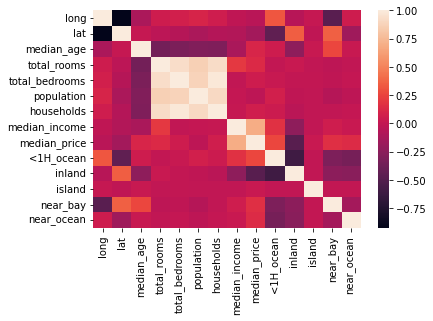

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(df.corr())
plt.show()

# Proposed Solution

One solution to our problem is to implement a multivariate regression model because we are utilizing multiple variables, such as proximity to the ocean, total rooms within a block, and number of households within a block, to predict the numerical housing prices for a given neighborhood.  Using the form $y_i = \mathbf{w}x + b$, we will find the optimal weight values analytically because linear regression provides a closed form solution rather than forcing us to go through gradient descent. 

We are also planning on trying a k-nearest neighbors model when doing model selection to determine the best model to approach our problem. This will cluster the neighborhoods in our training data into groups based on their similarities to each other. During testing, the kNN model will determine which cluster the test data is most similar to and predict the housing prices based on that. Because we only have ten variables, the dimension of the features is small enough that we won’t have problems with having a too large dimension where all the neighbors are far from each other.

We will select our algorithm through nested cross-validation, where the inner loop selects the best hyperparameters for each algorithm, and the outer loop determines which algorithm performed better on the test data. Once we have selected an algorithm, we will use cross validation in combination with random search to select hyperparameters to best optimize our model. We will use the Python library sklearn.


# Evaluation Metrics

For our multivariate regression model, we are planning on mean absolute error (MAE), which is represented by the following formula:  

\begin{align*}
	\text{MAE } &= |y_i - (\mathbf{w}x_i + b)| \\
\end{align*}

House prices have many outliers, for example houses that are priced extremely high, so we don’t want to rely on mean squared error. We will instead use mean absolute error, which is not as affected by outliers. By using MAE, we can make better predictions about housing prices. 


# Preliminary results

NEW SECTION!

Please show any preliminary results you have managed to obtain.

Examples would include:
- Analyzing the suitability of a dataset or alogrithm for prediction/solving your problem 
- Performing feature selection or hand-designing features from the raw data. Describe the features available/created and/or show the code for selection/creation
- Showing the performance of a base model/hyper-parameter setting.  Solve the task with one "default" algorithm and characterize the performance level of that base model.
- Learning curves or validation curves for a particular model
- Tables/graphs showing the performance of different models/hyper-parameters



In [5]:
X = df.drop('median_price',axis=1)
X = X.drop('ocean_proximity',axis=1)
y = df['median_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

standardizer = StandardScaler()

#Standardizing the values
X_train = standardizer.fit_transform(X_train)
X_test = standardizer.fit_transform(X_test)

In [6]:
linReg = LinearRegression()
linReg.fit(X_train,y_train)
y_pred = linReg.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)
print('mse: ', mse)
print('r2: ',r2)

RMSE: 67462.04821148927
mse:  4551127948.889301
r2:  0.6567605945920528


In [ ]:
randomForest = RandomForestRegressor(random_state = 42)
randomForest.fit(X_train,y_train)
y_pred = randomForest.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)
print('mse: ', mse)
print('r2: ',r2)

In [ ]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)
print('mse: ', mse)
print('r2: ',r2)

In [ ]:
decisionTree = DecisionTreeRegressor()
decisionTree.fit(X_train, y_train)
y_pred = decisionTree.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)
print('mse: ', mse)
print('r2: ',r2)

| Model | RMSE| MSE| R2 |
|---|---|---|---|
| Linear Regression | 67462.04821148927 | 4551127948.889301 | 0.6567605945920528
| Random Forest  |  56263.9063796054 |  3165627161.0930014  | 0.7612530351334144 | 
| K Nearest Neighbors  |  61452.764703791036 |  3776442289.7395053 | 0.7151862525851516 | 
| Decision Tree | 79479.25834478499 | 6316952507.037075 | 0.5235846922223312 |

In [ ]:
import matplotlib.pyplot as plt

rmse_values = [67462.048, 56263.906, 61452.764, 79479.258]
mse_values = [4551127948.889301, 3165627161.0930014, 3776442289.7395053, 6316952507.037075]
r2_values = [0.6567605945920528, 0.7612530351334144, 0.7151862525851516, 0.5235846922223312]

models = ['Linear Regression', 'Random Forest', 'KNN', 'Decision Tree']

plt.figure(figsize=(10, 5))
plt.bar(models, rmse_values)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE Comparison of Models')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(models, mse_values)
plt.xlabel('Models')
plt.ylabel('MSE')
plt.title('MSE Comparison of Models')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(models, r2_values)
plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.title('R2 Score Comparison of Models')
plt.show()

# Ethics & Privacy
We understand and are aware that our project should follow certain ethics and data privacy guidelines. The Kaggle dataset we are using pulls from the 1990 US census data, which means a lot of standard concerns about personally identifiable information or informed consent are already taken care of. However, we understand that there might be some ethical implications when we consider other factors that affect housing prices that aren’t included in the dataset — for example the racial makeup of the population. Because the data only looks at limited aspects/variables, there may be bias or factors that we fail to consider in our predictions.


# Team Expectations
* Equal contribution from each team member
* Communication throughout the course of the project, especially if someone is struggling with their assigned work
* Getting work done by agreed-upon deadlines
* Setting meeting goals of what to talk about
* Accountability (if necessary) in terms of work progress
* Looking over each project checkpoint as a group before turning it in

# Project Timeline Proposal

UPDATE THE PROPOSAL TIMELINE ACCORDING TO WHAT HAS ACTUALLY HAPPENED AND HOW IT HAS EFFECTED YOUR FUTURE PLANS

| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 5/22 | 10:30 AM | (hopefully) look over proposal corrections | plan of action before checkpoint #2
| 5/24  |  10:30 AM |  understand division of work + have started individual parts  | evaluate work in progress + make any logistical corrections necessary | 
| 5/28  |  10:30 AM |  understand division of work + have started individual parts  | continue to evaluate work in progress + make any logistical corrections necessary | 
| 5/30  |  6:00 PM |  finish individual parts of checkpoint work | discuss preliminary results + plan for further work + edit & finalize formatting for checkpoint #2 and submit | 
| 6/3 | 10:30 AM | (hopefully) look over checkpoint #2 corrections | plan of action for continuing work (divide up further tasks)
| 6/5 | 10:30 AM | understand division of work + have started individual parts | evaluate work in progress + make any logistical corrections necessary
| 6/7  | 10:30 AM  | significant progress on tasks post-checkpoint #2  | discuss results + analysis, divide up sections of the report to complete
| 6/14  | 10:30 AM  | have completed all work on the project | edit & finalize formatting for final project notebook and submit 